# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd #импортируем библиотеки
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import time
from sklearn import preprocessing
import lightgbm as ltb
from sklearn.preprocessing import StandardScaler

In [2]:
try: 
    df = pd.read_csv('/datasets/autos.csv')
except: 
    df = pd.read_csv("autos.csv")

In [3]:
df.info() # получим общую информацю об импортируемых данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.columns = df.columns.str.lower() # Заменим названия столбцов (приведем к нижнему регистру)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

### Описание данных

* Признаки </br> 

DateCrawled — дата скачивания анкеты из базы </br> 

VehicleType — тип автомобильного кузова </br>

RegistrationYear — год регистрации автомобиля </br>

Gearbox — тип коробки передач </br>

Power — мощность (л. с.) </br>

Model — модель автомобиля </br>

Kilometer — пробег (км) </br>

RegistrationMonth — месяц регис </br>

Brand — марка автомобиля </br>

NotRepaired — была машина в ремонте или нет </br>

DateCreated — дата создания анкеты </br>

NumberOfPictures — количество фотографий автомобиля </br>

PostalCode — почтовый индекс владельца анкеты (пользователя) </br>

LastSeen — дата последней активности пользователя </br>

* Целевой признак </br>
Price — цена (евро)

Признак "PostalCode" не имеет значения для дальнейших вычислений (не несет информативной цености), удалим его:

In [7]:
df = df.drop('postalcode', axis=1)

Приведем признаки "datecreated", "lastseen" к формату Даты: 

In [8]:
df["datecreated"] = pd.to_datetime(df["datecreated"])

In [9]:
df["lastseen"] = pd.to_datetime(df["lastseen"])

In [10]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,2016-04-06 10:17:21


Проверим имеются ли пропуски в значениях:

In [11]:
df.isnull().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
lastseen                 0
dtype: int64

Обработка пропусков значений: 

    - введем новую категорию unknown (неизвестно) и заменим на нее пропуски в признаках "vehicletype", "model",
    "notrepaired", "gearbox", "fueltype". 

In [12]:
df["vehicletype"] = df["vehicletype"].fillna("unknown")

In [13]:
df["model"] = df["model"].fillna("unknown")

In [14]:
df["notrepaired"] = df["notrepaired"].fillna("unknown")

In [15]:
df["gearbox"] = df["gearbox"].fillna("unknown")

In [16]:
df["fueltype"] = df["fueltype"].fillna("unknown")

In [17]:
df.isnull().sum() # проверим

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
datecreated          0
numberofpictures     0
lastseen             0
dtype: int64

In [18]:
df.describe() # оценим статистические данные

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0


Заметим, что "numberofpictures" все время равно 0. Также удалим этот столбец, т.к не предствляет значения.

In [19]:
df = df.drop('numberofpictures', axis=1)

Избавимся от выбросов:

In [20]:
df_pivot = df.pivot_table(index= 'registrationyear', values = 'model', aggfunc = 'count') 
# постороим зависимость количества моделей от года регстрации автомобиля.

In [21]:
#<font color="red">❌ Комментарий ревьювера    У тебя не было импорта</font>
import matplotlib.pyplot as plt 

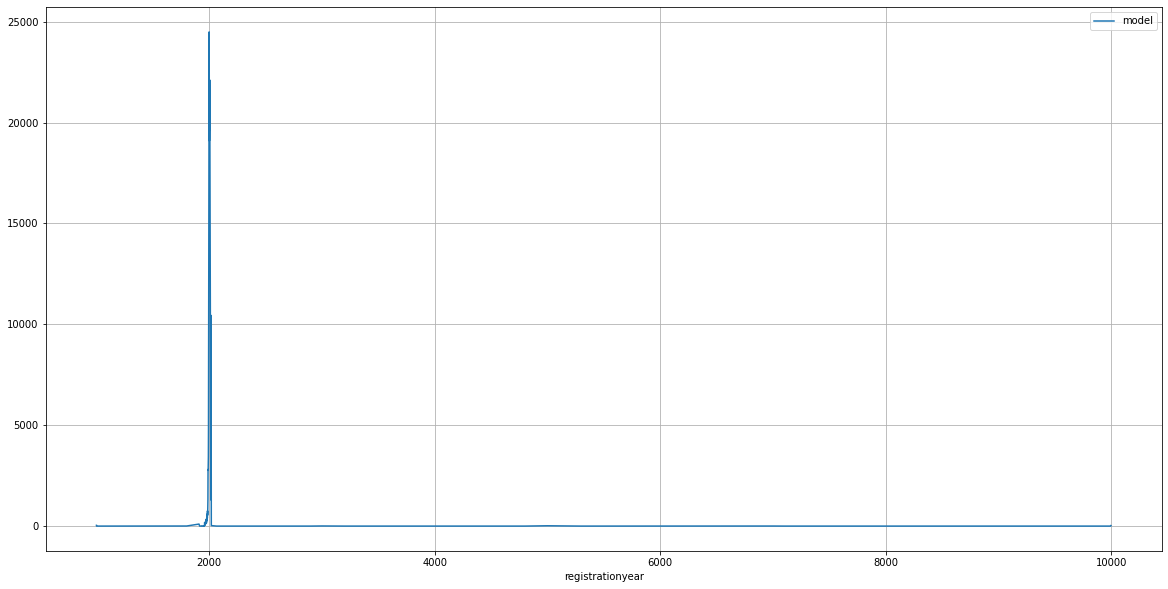

In [22]:
df_pivot.plot(figsize =(20,10), grid = True)
plt.show()

Видим, что присутствует большое количество выбросов: ограничимся интервалом года выпуска от 1970 до 2017: 

In [23]:
df = df.query('registrationyear <= 2017 and registrationyear >= 1970')

In [24]:
df["registrationyear"].max()

2017

In [25]:
df_pivot2 = df.pivot_table(index= 'registrationyear', values = 'model', aggfunc = 'count') 
# постороим зависимость количества моделей от года регстрации автомобиля.

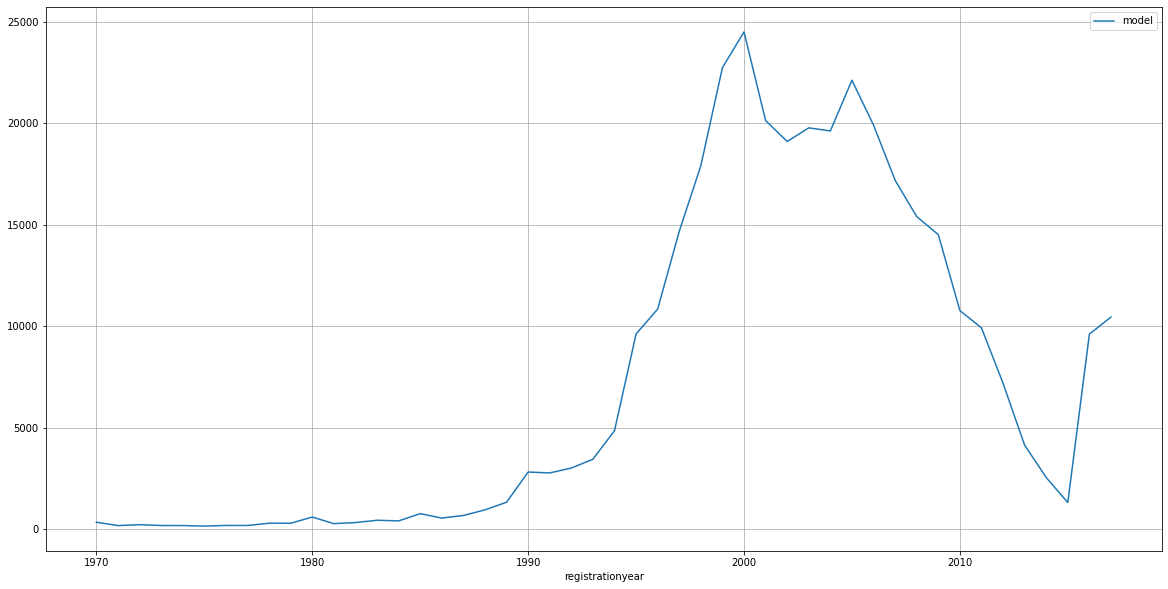

In [26]:
df_pivot2.plot(figsize =(20,10), grid = True)
plt.show()

Аналогично постоим зависимость количества моделей от мощности двигателя.

In [27]:
df_power = df.pivot_table(index= 'power', values = 'model', aggfunc = 'count') 
# постороим зависимость количества моделей от мощности автомобиля.

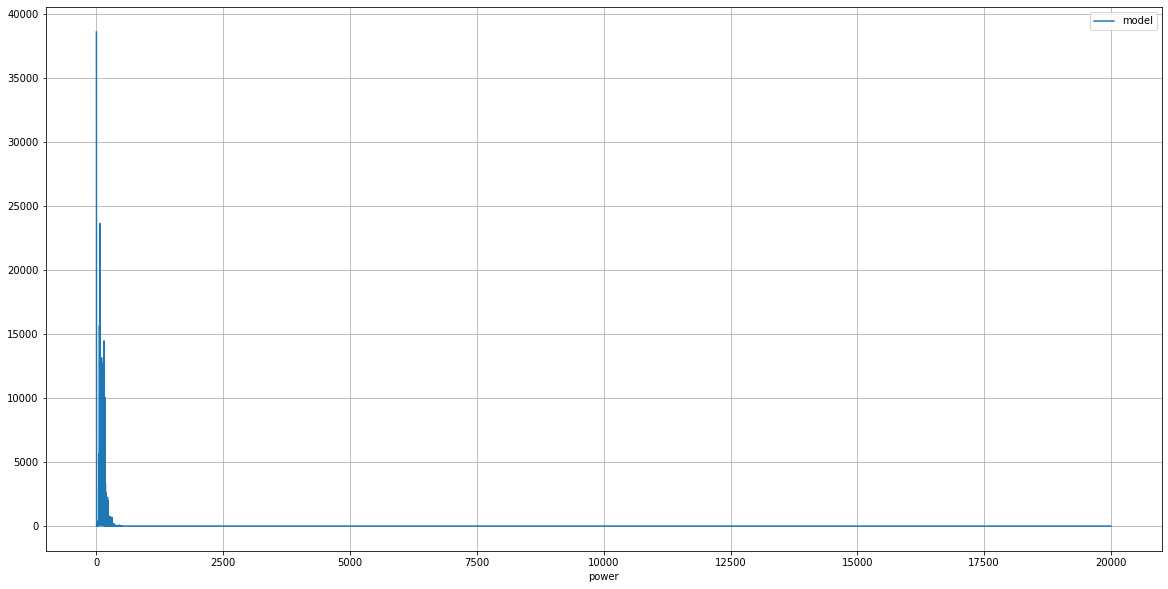

In [28]:
df_power.plot(figsize =(20,10), grid = True)
plt.show()

Видим, что также писутствуют выбросы. Ограничим мощность двигателя. 

In [29]:
df = df.query('power <= 350 and power >= 50')

In [30]:
df_power2 = df.pivot_table(index= 'power', values = 'model', aggfunc = 'count') 

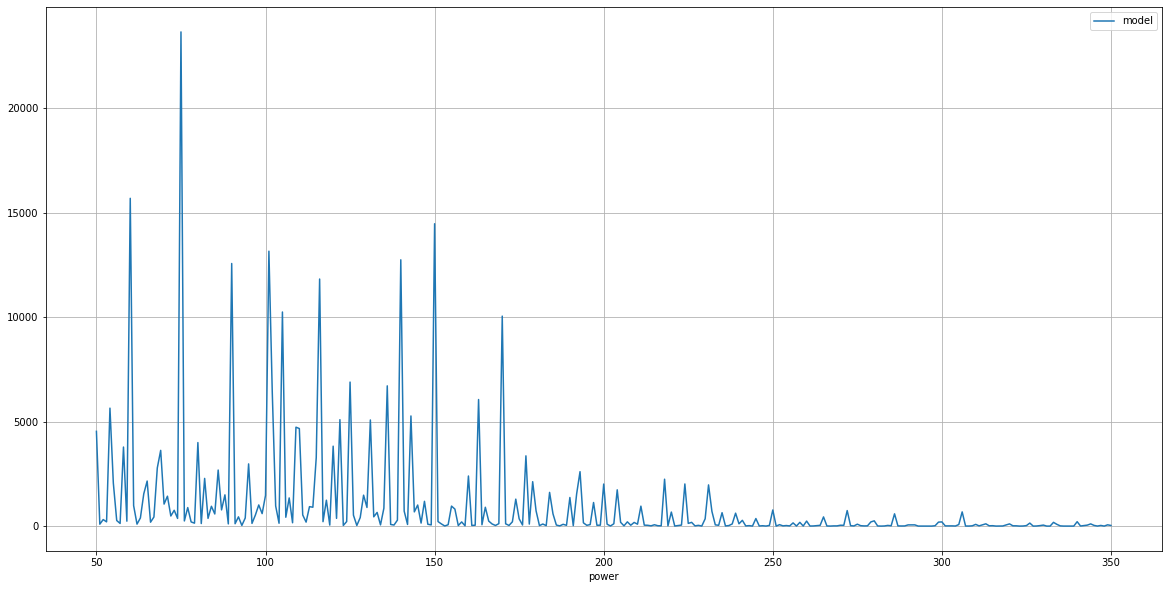

In [31]:
df_power2.plot(figsize =(20,10), grid = True)
plt.show()

<font color="green">✔️ Комментарий ревьювера   
Хорошо, согласен.  </font>


Избавились от выбросов. Далее выберем значения, где год регитсрации автомобиля не превышает дату создания анкеты. 

In [32]:
df["year_created"] = pd.DatetimeIndex(df["datecreated"]).year # создадим столбец год создания анкеты

Определим имеются ли значения: где год регистрации автомобиля "registrationyear" позже, чем год создания анкеты "year_created":

In [33]:
df_year = df.query('registrationyear > year_created')
df_year.shape

(7573, 15)

Получили вывод, в данных имеются ошибки: год регистрации автомобиля позже, чем создания анкеты. Удалим из общего DF подобные значения:

In [34]:
df_all = df.query('registrationyear <= year_created') # получили реальные данные
df_all.shape

(295995, 15)

In [35]:
df_all = df_all.drop("year_created", axis=1) # удалим вспомогательный столбец

Признаки "datecrawled", "datecreated", "lastseen" удалим, так как они бесполезны с точки зрения анализа и постороения модели. 

In [36]:
df_all = df_all.drop(columns = ['datecrawled', 'datecreated', 'lastseen'])

Кодирование данных:

<function matplotlib.pyplot.show(close=None, block=None)>

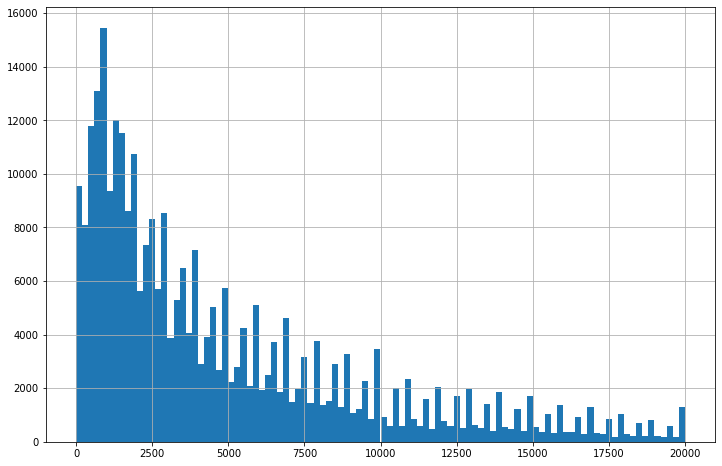

In [37]:
df_all["price"].hist(bins = 100, figsize=(12, 8)) # построим Гистограмму распределения цены. 
plt.show

Избавимся от значений цены = 0. Видимо, эти поля были не заполены. 

In [38]:
df_null = df_all[df_all["price"] == 0]
df_null.shape # аж 6146 значений цены равной 0. Удалим эти значения

(6146, 11)

In [39]:
df_all = df_all.query('price != 0')
df_all.shape

(289849, 11)

In [40]:
df_all_uncoder = df_all.copy() # сохраним выборку, чтобы далее использовать ее не кодируя при Гридиентном бустинге
df_all_uncoder.shape

(289849, 11)

- для кодирования признаков "model" и  "brand" применим метод OrdinalEncoder: 

In [41]:
ord_enc = OrdinalEncoder()

In [42]:
df_all["make_code_model"] = ord_enc.fit_transform(df_all[["model"]])

In [43]:
df_all["make_code_brand"] = ord_enc.fit_transform(df_all[["brand"]])

In [44]:
df_all.shape

(289849, 13)

In [45]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289849 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              289849 non-null  int64  
 1   vehicletype        289849 non-null  object 
 2   registrationyear   289849 non-null  int64  
 3   gearbox            289849 non-null  object 
 4   power              289849 non-null  int64  
 5   model              289849 non-null  object 
 6   kilometer          289849 non-null  int64  
 7   registrationmonth  289849 non-null  int64  
 8   fueltype           289849 non-null  object 
 9   brand              289849 non-null  object 
 10  notrepaired        289849 non-null  object 
 11  make_code_model    289849 non-null  float64
 12  make_code_brand    289849 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 31.0+ MB


- для кодирования данных применим метод прямого кодирования (OHE), т.к. он применяется - для номинальных категорий.

In [46]:
#column_ore = ["model", "brand"]
#column_ohe = ["vehicletype", "gearbox", "fueltype", "notrepaired"]
#df_all[column_ore] = ord_enc.fit_transform(df_all[column_ore])

#df_all = pd.get_dummies(df_all, columns=column_ohe, drop_first=True)
#df_all.head()

In [47]:
data_ohe_pred = df_all[["vehicletype", "gearbox", "fueltype", "notrepaired"]]

In [48]:
data_ohe = pd.get_dummies(data_ohe_pred, drop_first=True)

In [49]:
df_all = df_all.join(data_ohe)

Уберем из DF оригинальные столбцы, которые кодировали.

In [50]:
df_rezult = df_all.drop(["model", "vehicletype", "gearbox", "fueltype", "brand", "notrepaired"], axis=1)

разобъем данные на выборки (обучающая, валидационная): 

In [51]:
features_train, features_valid, target_train, target_valid = train_test_split(
    df_rezult.drop('price', axis=1), df_rezult.price, test_size=0.25, random_state=12345)

In [52]:
features_train.shape, features_valid.shape, target_train.shape, target_valid.shape

((217386, 25), (72463, 25), (217386,), (72463,))

Проведем масштабирование признаков:

In [53]:
scaler_train = StandardScaler()

In [54]:
scaler_train.fit(features_train)

StandardScaler()

In [55]:
features_train = scaler_train.transform(features_train)

In [56]:
scaler_valid = StandardScaler()

In [57]:
scaler_valid.fit(features_valid)

StandardScaler()

In [58]:
features_valid = scaler_train.transform(features_valid)

In [59]:
features_valid = scaler_train.transform(features_valid)

C:\Users\Nela\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Обучение моделей

In [60]:
def rmse (target_valid, predictions):
    return mean_squared_error(target_valid, predictions, squared=False)

Рассмотрим на модели Линейная регрессия

In [61]:
Start1 = time.time()
model_lr = LinearRegression() # инициализируем модель 
model_lr.fit(features_train, target_train) # обучим модель на тренировочной выборке
Stop1 = time.time()
Start2 = time.time()
predictions = model_lr.predict(features_valid)
rmse_lr = rmse(target_valid, predictions)
Stop2 = time.time()
print("Среднеквадратическая ошибка модели методом Линейной регрессии: ", rmse_lr)
time_lr_train = round(Stop1 - Start1, 3)
time_lr_pred = round(Stop2 - Start2, 3)
print("Время обучения: ", time_lr_train, "секунды,", "Время предсказания: ", time_lr_pred,  "секунды")

Среднеквадратическая ошибка модели методом Линейной регрессии:  510827.00630628556
Время обучения:  0.237 секунды, Время предсказания:  0.008 секунды


Рассмотрим на модели Дерево решений: 

In [62]:
model_tree = DecisionTreeRegressor()

Для моделей подберем оптимальное значение параметров: 

In [63]:
parametrs = { 'max_depth': range (1,13, 1), # глубина дерева от 1 до 13 с шагом 1
             'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2)
              }

In [64]:
# grid = GridSearchCV(model_tree, parametrs, cv=5) # Очень долго считаются параметры, сразу подставим посчитанные значения
# grid.fit(features_train, target_train)

In [65]:
# grid.best_params_ # Здесь и далее сразу подставим полученные параметры

In [66]:
Start1 = time.time()
model_tree = DecisionTreeRegressor(random_state = 12345, max_depth = 12, min_samples_leaf = 7, min_samples_split = 2)
model_tree.fit(features_train, target_train) # обучим
Stop1 = time.time()

Start2 = time.time()
predictions_tree = model_tree.predict(features_valid)
Stop2 = time.time()

rmse_tree = rmse(target_valid, predictions_tree)
print("Среднеквадратическая ошибка модели методом Дерево решений: ", rmse_tree)

time_tree_train = round(Stop1 - Start1, 3)
time_tree_pred = round(Stop2 - Start2, 3)
print("Время обучения: ", time_tree_train, "секунды,", "Время предсказания: ", time_tree_pred,  "секунды")

Среднеквадратическая ошибка модели методом Дерево решений:  4729.962160242359
Время обучения:  0.914 секунды, Время предсказания:  0.009 секунды


Рассмотрим модель Градиентный бустинг (метод CatBoost):

In [67]:
df_all_uncoder.shape # возьмем DF без кодирования

(289849, 11)

Приведем категориальные переменные к типу данных 'category':

In [68]:
df_all_uncoder[["vehicletype", "gearbox", "model", "fueltype", "brand", "notrepaired"]] =\
df_all_uncoder[["vehicletype", "gearbox", "model", "fueltype", "brand", "notrepaired"]].astype("category")

In [69]:
df_all_uncoder["price"] = df_all_uncoder["price"].astype("int")

In [70]:
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(
    df_all_uncoder.drop('price', axis=1), df_all_uncoder.price, test_size=0.25, random_state=12345)
# разобъем на выборки

In [71]:
features_train1.shape, features_valid1.shape, target_train1.shape, target_valid1.shape

((217386, 10), (72463, 10), (217386,), (72463,))

In [72]:
model_cb = CatBoostRegressor()

In [73]:
parametrs = { 'iterations': range (1, 3), 'learning_rate': range (1, 3), 'depth': range (1, 5)}   

In [74]:
# grid = GridSearchCV(model_cb, parametrs, cv=5) 
# grid.fit(features_train, target_train)

In [75]:
# grid.best_params_ 

In [76]:
model_cb_optimal = CatBoostRegressor(iterations=2, learning_rate=1, depth=4)

In [77]:
Start1 = time.time()
cat_features = ["vehicletype", "registrationyear", "gearbox", "gearbox", "power", "model", "kilometer", "registrationmonth",\
                "fueltype", "brand", "notrepaired"]
model_cb_optimal.fit(features_train1, target_train1, cat_features = cat_features)
Stop1 = time.time()

Start2 = time.time()
predictions_cb = model_cb_optimal.predict(features_valid1)
Stop2 = time.time()

rmse_cb = rmse(target_valid1, predictions_cb)
print("Среднеквадратическая ошибка модели Градиентный бустинг методом catboost: ", rmse_cb)

time_cb_train = round(Stop1 - Start1, 3)
time_cb_pred = round(Stop2 - Start2, 3)
print("Время обучения: ", time_cb_train, "секунды,", "Время предсказания: ", time_cb_pred,  "секунды")

0:	learn: 3041.8593019	total: 153ms	remaining: 153ms
1:	learn: 2745.0419441	total: 220ms	remaining: 0us
Среднеквадратическая ошибка модели Градиентный бустинг методом catboost:  2743.960970150209
Время обучения:  0.803 секунды, Время предсказания:  0.141 секунды


Рассмотрим модель Градиентного бустинга методом LightGBM: 

In [78]:
scoring_fit = 'neg_mean_squared_error'

In [79]:
model_lgbm = LGBMRegressor(random_state = 54321)

In [80]:
param_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10, 12]}

In [81]:
gs = GridSearchCV(model_lgbm, param_grid, cv = 5, scoring = scoring_fit)

In [82]:
#gs.fit(features_train1, target_train1)

In [83]:
# gs.best_params_  # наилучшие параметры {'max_depth': 5, 'n_estimators': 100}

In [84]:
model_lgbm_optim = LGBMRegressor(random_state = 54321, max_depth = 5, n_estimators = 100)
Start1 = time.time()
model_lgbm_optim.fit(features_train1, target_train1)
Stop1 = time.time() 

In [85]:
Start2 = time.time()
predictions_lgbm = model_lgbm_optim.predict(features_valid1)
Stop2 = time.time()

In [86]:
rmse_lgbm = rmse(target_valid1, predictions_lgbm)
print("Среднеквадратическая ошибка модели Градиентный бустинг методом LGBM: ", rmse_lgbm)
time_lgbm_train = round(Stop1 - Start1, 3)
time_lgbm_pred = round(Stop2 - Start2, 3)
print("Время обучения: ", time_lgbm_train, "секунды,", "Время предсказания: ", time_lgbm_pred,  "секунды")

Среднеквадратическая ошибка модели Градиентный бустинг методом LGBM:  1597.2985485522902
Время обучения:  0.745 секунды, Время предсказания:  0.167 секунды


## Анализ моделей

Получим таблицу с результатами:

In [87]:
rez = pd.DataFrame({"модель": ["Линейная регрессия", "Дерево решений", "Градиентный бустинг (CatBoost)",\
                              "Градиентный бустинг (LGBM)"], "значение RMSE": [rmse_lr, rmse_tree, rmse_cb, rmse_lgbm],\
                   "Время обучения: ": [time_lr_train, time_tree_train, time_cb_train, time_lgbm_train],\
                    "Время предсказания: ": [time_lr_pred, time_tree_pred, time_cb_pred, time_lgbm_pred]})

In [88]:
rez

,модель,значение RMSE,Время обучения:,Время предсказания:
0,Линейная регрессия,510827.006306,0.237,0.008
1,Дерево решений,4729.962160,0.914,0.009
2,Градиентный бустинг (CatBoost),2743.960970,0.803,0.141
3,Градиентный бустинг (LGBM),1597.298549,0.745,0.167


Из таблицы видно, что лучший результат значения среднеквадратической ошибки предсказания показывает модель Градиентного бустинга LightGBM, однако у этой модели самое большое время обучения. Наименьшее время обучения у модели Линейная регрессия, наименьшее время предсказания у модели Дерево решений.  

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей